# Chapter 3 Part 1<br>Content-Based Joke Recommendation 
## <br>Dawei Wang

In this chapter, you will explore content-based filtering methods for recommendation. Specifically, you'll learn how you can extract features from content associated with items, represent items as feature vectors, create user profiles, and generate both personalized and non-personalized content-based recommendations. In the second part of this assignment, you'll learn how to do more systematic parameter optimization for different recommendation models. For this task you'll use the Surprise package.

In [1]:
import os
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import nltk      
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
from platform import python_version
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('max_columns',200)
pd.set_option('display.precision',2)

print('Version list\n')
print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(sp.__name__, sp.__version__)
print(sns.__name__, sns.__version__)
print(matplotlib.__name__, matplotlib.__version__)
print(nltk.__name__, nltk.__version__)

Version list

python 3.9.7
numpy 1.22.2
pandas 1.3.5
scipy 1.7.3
seaborn 0.11.2
matplotlib 3.5.1
nltk 3.7


### 1a

Read in the joke ratings data as well as joke text data into appropriate data structures. First, preprocess the joke text data (tokenization, stop word removal, stemming) and create feature vector representation of jokes with TFxIDF weights. Note that for some of the preprocessing steps, you may need to install NLTK package if not already installed with your Anaconda distribution. For the vectorization, you can use functions from Scikit-learn's feature_extraction.text module. Show the feature set or the vocabulary for the item vectors.

In [2]:
os.chdir('/Users/daweiwang/Desktop/CSC 577/Assignments')

<font size =4>*Import joke and rate dataset and transfer them to DataFrame*

In [3]:
# use a function to transfer text document into appropriate data structure
def load_jokes(file):
    jokes = np.genfromtxt(file, delimiter=',', dtype=str)
    jokes = np.array(jokes[:,1])
    return jokes
joke = load_jokes("jokes.csv")
rate = np.loadtxt('joke-ratings.csv', delimiter =',')

In [4]:
joke.shape

(100,)

In [5]:
joke[0]

'A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease". The man replies "Well thank God I don\'t have cancer!"'

In [6]:
jokes = pd.DataFrame(joke, columns=['text'])
jokes

,text
0,"A man visits the doctor. The doctor says ""I ha..."
1,This couple had an excellent relationship goin...
2,Q. What's 200 feet long and has 4 teeth? A. Th...
3,Q. What's the difference between a man and a t...
4,Q. What's O. J. Simpson's Internet address? A....
...,...
95,Two attorneys went into a diner and ordered tw...
96,A teacher is explaining to her class how diffe...
97,Age and Womanhood1. Between the ages of 13 and...
98,A bus station is where a bus stops.A train sta...


In [7]:
rate.shape

(1000, 100)

In [8]:
rate

array([[ 3., 19.,  1., ...,  0.,  0.,  0.],
       [15., 10., 17., ..., 11.,  6., 12.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [16., 16., 15., ...,  0.,  0.,  0.],
       [ 3.,  4.,  3., ...,  3.,  3.,  3.],
       [ 9., 11.,  9., ...,  0.,  0.,  0.]])

<font size = 4>*Get Stop Words from local file*

In [9]:
def get_stop_words():
    result = set()
    for line in open('stopwords_en.txt', 'r').readlines():
        result.add(line.strip())
    return result

In [10]:
stop_words = get_stop_words()

<font size = 4>*Tokenize the documents and create as document-feature matrix*

In [17]:
# use local stop words text file 
vectorizer = TfidfVectorizer(stop_words=stop_words, norm=None, max_df=0.8, min_df=3)

In [18]:
joke_mat = vectorizer.fit_transform(jokes['text'])
joke_mat

<100x140 sparse matrix of type '<class 'numpy.float64'>'
	with 690 stored elements in Compressed Sparse Row format>

In [19]:
print(joke_mat[0:100])

  (0, 26)	3.312535423847214
  (0, 95)	3.217225244042889
  (0, 83)	4.005682604407159
  (0, 5)	4.228826155721369
  (0, 101)	2.2478246868547855
  (0, 24)	8.457652311442738
  (0, 72)	5.563814345570087
  (1, 86)	3.5356789751614235
  (1, 136)	3.6692103677859462
  (1, 133)	4.228826155721369
  (1, 10)	4.005682604407159
  (1, 94)	3.217225244042889
  (1, 71)	3.6692103677859462
  (1, 99)	3.217225244042889
  (1, 121)	8.011365208814318
  (1, 2)	3.130213867053259
  (1, 134)	3.8233610476132043
  (1, 51)	4.005682604407159
  (1, 13)	4.005682604407159
  (1, 21)	3.5356789751614235
  (1, 40)	3.5356789751614235
  (1, 20)	4.005682604407159
  (2, 65)	3.8233610476132043
  (2, 33)	4.228826155721369
  (3, 124)	4.005682604407159
  :	:
  (92, 94)	3.217225244042889
  (92, 99)	9.651675732128666
  (92, 2)	3.130213867053259
  (93, 84)	3.6692103677859462
  (93, 104)	4.005682604407159
  (93, 125)	3.5356789751614235
  (93, 95)	3.217225244042889
  (93, 101)	4.495649373709571
  (94, 4)	4.228826155721369
  (94, 55)	2.97606

In [20]:
features = vectorizer.get_feature_names_out()
print(features[10:220])

['big' 'boy' 'bulb' 'came' 'car' 'change' 'clinton' 'come' 'company'
 'country' 'couple' 'day' 'did' 'difference' 'doctor' 'does' 'don' 'door'
 'drink' 'eating' 'end' 'engineer' 'father' 'feet' 'finally' 'fine'
 'funny' 'girl' 'gives' 'goes' 'going' 'good' 'got' 'great' 'ground'
 'group' 'guy' 'having' 'head' 'hell' 'hillary' 'home' 'hot' 'husband'
 'jewish' 'just' 'know' 'languages' 'later' 'left' 'light' 'lightbulb'
 'like' 'little' 'll' 'long' 'look' 'looking' 'looks' 'lot' 'love' 'make'
 'man' 'married' 'mechanical' 'men' 'mess' 'met' 'minutes' 'morning'
 'mother' 'need' 'new' 'news' 'oh' 'okay' 'old' 'orders' 'paid' 'pass'
 'person' 'problem' 'pulls' 'recent' 'replied' 'replies' 'returns' 'room'
 'runs' 'said' 'say' 'says' 'school' 'screw' 'second' 'sir' 'sits' 'sleep'
 'sleeping' 'son' 'start' 'started' 'straight' 'students' 'takes'
 'teacher' 'tell' 'tells' 'thing' 'think' 'time' 'told' 'took' 'turns'
 'use' 've' 'voice' 'walks' 'want' 'went' 'wife' 'woman' 'won' 'word'
 'work' 

In [21]:
vectorizer.vocabulary_

{'man': 72,
 'doctor': 24,
 'says': 101,
 'bad': 5,
 'news': 83,
 'replies': 95,
 'don': 26,
 'couple': 20,
 'going': 40,
 'day': 21,
 'came': 13,
 'home': 51,
 'work': 134,
 'asked': 2,
 'told': 121,
 'said': 99,
 'make': 71,
 'replied': 94,
 'big': 10,
 'word': 133,
 'year': 136,
 'old': 86,
 'feet': 33,
 'long': 65,
 'difference': 23,
 'use': 124,
 'hillary': 50,
 'pulls': 92,
 'runs': 98,
 'school': 102,
 'car': 14,
 'say': 100,
 'good': 41,
 'turns': 123,
 'married': 73,
 've': 125,
 'wife': 130,
 'does': 25,
 'screw': 103,
 'light': 60,
 'bulb': 12,
 'funny': 36,
 'did': 22,
 'country': 19,
 'guy': 46,
 'goes': 39,
 'bar': 6,
 'got': 42,
 'like': 62,
 'returns': 96,
 'okay': 85,
 'come': 17,
 'just': 55,
 'start': 110,
 'eating': 29,
 'looking': 67,
 'finally': 34,
 'hell': 49,
 'answers': 1,
 'want': 128,
 'morning': 79,
 'father': 32,
 'boy': 11,
 'yes': 138,
 'sir': 105,
 'minutes': 78,
 'later': 58,
 'girl': 37,
 'left': 59,
 'mess': 76,
 'straight': 112,
 'person': 90,
 'men

In [12]:
def normalize_document(doc):
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    ps = nltk.stem.PorterStemmer()
    # convert to lower case, and remove special characters and white space
    doc = re.sub(r'[^a-zA-Z0-9_\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize the document
    tokens = wpt.tokenize(doc)
    # remove stopwords
    filtered_tokens = [token for token in tokens if (token not in stop_words and token not in ["."])]
    # put the filtered document back together
    doc = ' '.join([ps.stem(token) for token in filtered_tokens])
    return doc

In [13]:
# use nltk stop words 
vectorizer2 = TfidfVectorizer(preprocessor=normalize_document, norm=None, max_df=0.8, min_df=3)

In [14]:
vectorizer2.fit(jokes['text'])

TfidfVectorizer(max_df=0.8, min_df=3, norm=None,
                preprocessor=<function normalize_document at 0x28a01ddc0>)

In [15]:
joke_mat2 = vectorizer2.transform(jokes['text'])
joke_mat2

<100x186 sparse matrix of type '<class 'numpy.float64'>'
	with 1005 stored elements in Compressed Sparse Row format>

In [16]:
features2 = vectorizer2.get_feature_names_out()
print(features2[10:20])
vectorizer2.vocabulary_

['back' 'bad' 'bar' 'bartend' 'beauti' 'beer' 'big' 'bill' 'boy' 'breath']


{'man': 91,
 'doctor': 38,
 'say': 137,
 'bad': 11,
 'news': 107,
 'repli': 130,
 'well': 173,
 'coupl': 32,
 'go': 60,
 'one': 113,
 'day': 33,
 'came': 23,
 'home': 73,
 'work': 181,
 'find': 53,
 'ask': 8,
 'told': 163,
 'thing': 157,
 'could': 30,
 'possibl': 122,
 'said': 136,
 'make': 90,
 'big': 16,
 'word': 180,
 'year': 184,
 'old': 112,
 'what': 175,
 'feet': 51,
 'long': 86,
 'differ': 37,
 'around': 6,
 'use': 169,
 'bill': 17,
 'hillari': 72,
 'back': 10,
 'pull': 125,
 'run': 135,
 'school': 138,
 'car': 24,
 'window': 178,
 'good': 62,
 'turn': 166,
 'marri': 93,
 'wife': 177,
 'would': 182,
 'presid': 123,
 'mani': 92,
 'take': 154,
 'screw': 139,
 'light': 82,
 'funni': 56,
 'hear': 70,
 'countri': 31,
 'guy': 67,
 'goe': 61,
 'bar': 12,
 'demand': 35,
 'got': 63,
 'like': 83,
 'return': 133,
 'okay': 111,
 'resourc': 131,
 'come': 27,
 'start': 149,
 'anyth': 5,
 'two': 167,
 'eat': 42,
 'someon': 146,
 'seem': 142,
 'look': 87,
 'measur': 94,
 'hell': 71,
 'answer': 

<font size =4>*Similarities between items and documents*

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
sim_mat = cosine_similarity(joke_mat2)
sim_mat.shape

(100, 100)

In [23]:
np.set_printoptions(linewidth=120, precision=2, edgeitems=10)
print(sim_mat)

[[1.   0.03 0.   0.16 0.   0.04 0.   0.   0.02 0.04 ... 0.   0.   0.09 0.12 0.   0.   0.02 0.   0.   0.  ]
 [0.03 1.   0.   0.   0.   0.07 0.   0.   0.   0.03 ... 0.01 0.11 0.16 0.06 0.   0.14 0.11 0.   0.18 0.04]
 [0.   0.   1.   0.23 0.51 0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25]
 [0.16 0.   0.23 1.   0.45 0.   0.   0.   0.11 0.   ... 0.   0.   0.   0.   0.   0.   0.13 0.   0.   0.4 ]
 [0.   0.   0.51 0.45 1.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.49]
 [0.04 0.07 0.   0.   0.   1.   0.   0.   0.06 0.1  ... 0.13 0.11 0.12 0.08 0.   0.   0.02 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.27 ... 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   ... 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.   0.11 0.   0.06 0.   0.   1.   0.03 ... 0.09 0.02 0.13 0.04 0.   0.04 0.01 0.2  0.   0.  ]
 [0.04 0.03 0.   0.   0.   0.1  0.27 

### 1b

Create a non-personalized recommender that, given a target/query item, returns the top k most similar items to the target item. Your function/program should use as input a pre-computed item-item similarity matrix, with Cosine similarity as metric, based on feature representations of items. Your recommender should output the texts of the query joke and the top k recommended jokes along with the similarity values to the query joke. Show the output of your recommender on jokes 19 and 46.



### The non-personalized recommender

In [59]:
def content_based_recommender(dataMat, simMat, item, k):
    '''dataMat = items Data Frame
       simMat  = similarity matrix 
       item    = target item index
       k       = top k most similar items'''
    if k <= simMat.shape[0]:
        sims = simMat[item,:]
        idx = np.argsort(sims)
        idx = idx[::-1]
        idx = np.array([i for i in idx if i != item])
        # top k items' index and similarities 
        # Descending order
        neigh_idx = idx[:k]
        neigh_sims = sims[neigh_idx]
        res = pd.DataFrame(columns=['Item index','Similarity','Item'])
    
        for i in range(k):
            res.loc[i]= [neigh_idx[i] , neigh_sims[i] , dataMat.iloc[neigh_idx[i]][0]]
            
        print('The query joke is No.{}:\n{}'.format(item, dataMat.iloc[item][0]))
    else: print('k cannot be bigger than total number of items') 
      
    return res

### Results for Joke No.19

In [60]:
content_based_recommender(jokes,sim_mat,19,10)

The query joke is No.19:
What's the difference between a MacIntosh and anEtch-A-Sketch? You don't have to shake the Mac to clear the screen.


,Item index,Similarity,Item
0,77,0.91,Q: What's the difference between the government and the Mafia? A: One of them is organized.
1,4,0.75,Q. What's O. J. Simpson's Internet address? A.\tSlash slash backslash slash slash escape.
2,29,0.66,Q: What's the difference between a Lawyer and a Plumber? A: A Plumber works to unclog the system.
3,99,0.65,Q: What's the difference between greeting a Queen and greeting thePresident of the United States?A: You only have to get on one knee to...
4,3,0.61,Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.
5,20,0.47,What's the difference between a used tire and 365 used condoms?One's a Goodyear the other's a great year.
6,2,0.38,Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.
7,72,0.37,Q: What is the difference between George Washington Richard Nixon and Bill Clinton? A: Washington couldn't tell a lie Nixon couldn't ...
8,74,0.33,Q: Do you know the difference between an intelligent male and theSasquatch? A: There have been actual reported sightings of the Sasquatch.
9,38,0.13,What is the difference between men and women:A woman wants one man to satisfy her every need.A man wants every woman to satisfy his one ...


### Results for Joke No. 46

In [64]:
a = content_based_recommender(jokes,sim_mat,19,10)
a
pd.options.display.max_colwidth = 130
a.style.set_properties(**{'text-align': 'left'})

The query joke is No.19:
What's the difference between a MacIntosh and anEtch-A-Sketch? You don't have to shake the Mac to clear the screen.


,Item index,Similarity,Item
0,77,0.91,Q: What's the difference between the government and the Mafia? A: One of them is organized.
1,4,0.75,Q. What's O. J. Simpson's Internet address? A. Slash slash backslash slash slash escape.
2,29,0.66,Q: What's the difference between a Lawyer and a Plumber? A: A Plumber works to unclog the system.
3,99,0.65,Q: What's the difference between greeting a Queen and greeting thePresident of the United States?A: You only have to get on one knee to greet the queen.
4,3,0.61,Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.
5,20,0.47,What's the difference between a used tire and 365 used condoms?One's a Goodyear the other's a great year.
6,2,0.38,Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.
7,72,0.37,Q: What is the difference between George Washington Richard Nixon and Bill Clinton? A: Washington couldn't tell a lie Nixon couldn't tell the truth andClinton doesn't know the difference.
8,74,0.33,Q: Do you know the difference between an intelligent male and theSasquatch? A: There have been actual reported sightings of the Sasquatch.
9,38,0.13,What is the difference between men and women:A woman wants one man to satisfy her every need.A man wants every woman to satisfy his one need.


In [57]:
content_based_recommender(jokes,sim_mat,46,10)

The query joke is No.46:
There was an engineer who had an exceptional gift for fixing all things mechanical.  After serving his company loyally for over 30 years he happily retired.  Several years later the company contacted him regarding a seemingly impossible problem they were having with one of their multi-million dollar machines. They had tried everything and everyone else to get the machine fixed but to no avail.  In desperation they called on the retired engineer who had solved so many of their problems in the past.The engineer reluctantly took the challenge.  He spent a day studying the huge machine.  At the end of the day he marked a small "x" in chalk on a particular component of the machine and proudly stated "This is where your problem is".The part was replaced and the machine worked perfectly again. The company received a bill for $50000 from the engineer for his service.They demanded an itemized accounting of his charges. The engineer responded briefly:One chalk mark      

,Item index,Similarity,Item
0,83,0.50,Q: What is the difference between Mechanical Engineers and Civil Engineers? A: Mechanical Engineers build weapons Civil Engineers build ...
1,92,0.49,"Reaching the end of a job interview the human resources person asked a young engineer fresh out of Stanford""And what starting salary wer..."
2,27,0.47,A mechanical electrical and a software engineer from Microsoft were driving through the desert when the car broke down. The mechanical e...
3,48,0.43,"Three engineering students were gathered together discussing the possible designers of the human body. One said ""It was a mechanical en..."
4,61,0.28,A group of managers were given the assignment to measure the height of a flagpole. So they go out to the flagpole with ladders and tape...
5,89,0.24,Q: How many programmers does it take to change a lightbulb?A: NONE! That's a hardware problem....
6,70,0.23,At a recent Sacramento PC Users Group meeting a company was demonstrating its latest speech-recognition software. A representative fro...
7,47,0.20,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The graduate ..."
8,62,0.15,An engineer a physicist and a mathematician are sleeping in a room. There is a fire in the room. The engineer wakes up sees the firepick...
9,54,0.15,"A woman has twins and gives them up for adoption. One of them goes to a family in Egypt and is named ""Amal."" The other goes to a fami..."


### 1c


For a personalized version of the content-based recommendation, you'll need to create user profiles for each user based on their past ratings on jokes. Use the following procedure for creating user profiles.

<br>&emsp;· We are going to assume that "liked" items by a user u are those jokes whose rating by u is greater than u's mean rating on all jokes rated by u (note that zeros don't count as ratings). These are the jokes from which user profiles for each user will be constructed. So, for each user you need to collect all jokes that satisfy this condition.

<br>&emsp;· Split the liked items for each user into a training and a test portions. Normally, we would use random splits, however, for consistency across different answers, in this case you should select the first half of items as the user profile to be used for training, and the second half to be set aside for testing purposes. For each user, you should maintain a list of indices of the items in the user profile (the known "liked" items used for training) as well as indices of items in the test portion of user's record (the withheld test "liked" items).

<br>&emsp;· Convert the user profiles for all users (this is the training portion of liked items you selected earlier) into feature vectors over the feature set created in 1(a). These vectors will be used as representations of user profiles to compute similarities with items

### Personalized version of the content-based recommender

In [123]:
r = pd.DataFrame(rate)

<font size=4>*Here I set half of users' joke as floor division of 2, this will lead to the test set slightly larger than trian set since the odd number of ratings will create an uneven split.*

In [130]:
# users' mean rating value for all none 0 ratings 
m  = r.sum(axis=1)/(r != 0).sum(axis=1)

In [189]:
u_train = pd.DataFrame() 
u_test = pd.DataFrame() 
# For each (user,joke) pair, take valid position's indices 
# In this 2D List, 1st column is user id, 2nd column is joke id
for i in range(1000):
    u = []
    for j in range(100):
        if r[j][i] > m[i]:
            u.append([i,j]) 
    z = len(u)//2
    u_train = u_train.append(u[:z])
    u_test = u_test.append(u[z:])

u_train.rename({0: 'User ID',1 : 'Joke ID'}, axis=1, inplace=True)
u_test.rename({0: 'User ID',1 : 'Joke ID'}, axis=1, inplace=True)

In [192]:
j = jokes.reset_index(inplace=False).rename(columns = {'index':'Joke ID'})

In [194]:
usrp_train = pd.merge(u_train,j,on='Joke ID')
usrp_train

,User ID,Joke ID,text
0,0,1,This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked ...
1,3,1,This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked ...
2,4,1,This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked ...
3,5,1,This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked ...
4,7,1,This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked ...
...,...,...,...
19003,593,79,"Hillary Bill Clinton and the Pope are sitting together on an airplane. Bill says ""I could throw one thousand dollar bill out o..."
19004,593,82,"What a woman says:""This place is a mess! C'monYou and I need to clean upYour stuff is lying on the floor and you'll have no c..."
19005,600,82,"What a woman says:""This place is a mess! C'monYou and I need to clean upYour stuff is lying on the floor and you'll have no c..."
19006,593,85,"A neutron walks into a bar and orders a drink.""How much do I owe you?"" the neutron asks.The bartender replies ""for you no char..."


In [193]:
usrp_test = pd.merge(u_test,j,on='Joke ID')
usrp_test

,User ID,Joke ID,text
0,0,47,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
1,2,47,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
2,6,47,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
3,7,47,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
4,9,47,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
...,...,...,...
19519,354,27,A mechanical electrical and a software engineer from Microsoft were driving through the desert when the car broke down. The me...
19520,791,27,A mechanical electrical and a software engineer from Microsoft were driving through the desert when the car broke down. The me...
19521,629,29,Q: What's the difference between a Lawyer and a Plumber? A: A Plumber works to unclog the system.
19522,663,22,Q: What is the Australian word for a boomerang that won't come back? A: A stick


<font size=4>*As we can see above, test set is a bit larger than train set.   
    Next, we will get text collection and indices:*

In [199]:
# liked items text collection of users 
usrtext_train= pd.DataFrame(usrp_train.groupby('User ID')['text'].agg(lambda x: x.str.cat(sep=';')))
usrtext_test = pd.DataFrame(usrp_test.groupby('User ID')['text'].agg(lambda x: x.str.cat(sep=';')))

In [200]:
# liked items indices dictionary of users 
usrCont_train = usrp_train.groupby('User ID')['Joke ID'].apply(list).to_dict()
usrCont_test = usrp_test.groupby('User ID')['Joke ID'].apply(list).to_dict()

In [202]:
user_profiles = vectorizer2.transform(usrtext_train['text'])

In [204]:
print(user_profiles[0:2])

  (0, 184)	9.651675732128666
  (0, 183)	3.8233610476132043
  (0, 182)	4.005682604407159
  (0, 181)	12.520855468213036
  (0, 180)	4.228826155721369
  (0, 179)	3.5356789751614235
  (0, 178)	12.686478467164108
  (0, 173)	3.41789593950504
  (0, 172)	6.260427734106518
  (0, 171)	11.628281262956197
  (0, 170)	12.686478467164108
  (0, 168)	4.005682604407159
  (0, 167)	2.842531794601478
  (0, 165)	4.228826155721369
  (0, 164)	3.8233610476132043
  (0, 163)	8.011365208814318
  (0, 158)	7.6467220952264086
  (0, 157)	11.470083142839613
  (0, 156)	6.625070847694428
  (0, 155)	12.017047813221478
  (0, 154)	8.721210947217148
  (0, 153)	4.228826155721369
  (0, 151)	4.228826155721369
  (0, 150)	7.6467220952264086
  (0, 149)	3.312535423847214
  :	:
  (1, 36)	4.005682604407159
  (1, 35)	4.228826155721369
  (1, 32)	4.005682604407159
  (1, 31)	8.457652311442738
  (1, 27)	7.071357950322847
  (1, 26)	7.6467220952264086
  (1, 25)	3.8233610476132043
  (1, 24)	3.6692103677859462
  (1, 23)	4.005682604407159
  (1

### 1d

Now that you have feature vector representations of users' profiles, implement a personalized content-based recommender. It should take the ratings data, the profile feature vector for a target user, and a list of item indices that are part of the target user's profile (i.e., the known "liked" items); and output the top k recommended items for the user (based on similarity to target user's profile). The recommended items must be different than the items already in the user profile (i.e. different from the training "liked" items). Test your recommender by generating the top 10 recommended jokes for user 0 (show the items in user's profile as well as the top 10 recommended jokes).

### The recommender for users:

In [226]:
def content_based_rec_user(dataMat, txtMat, user, user_p, like_in, k):
    '''dataMat = items Data Frame
       txtMat  = token count sparse matrix of text documents 
       user    = user ID
       user_p  = user profile vector
       like_in = liked items indices of user
       k       = top k most similar items'''
    #  get user profile for target user 
    u = user_p[user]
    
    from sklearn.metrics.pairwise import cosine_similarity
    sims = cosine_similarity(txtMat, u)
    # cosine_similarity returns a nx1 array; flatten it into a 1d numpy array
    sims = sims.flatten() 
    idx = np.argsort(sims)
    liked_indices = like_in[user]
    idx = np.array([i for i in idx if not (i in liked_indices)])
    idx = idx[::-1]
    neigh_idx = idx[:k]
    neigh_sims = sims[neigh_idx]
    res = pd.DataFrame(columns=['Item index','Similarity','Item'])
    for i in range(k):
            res.loc[i]= [neigh_idx[i] , neigh_sims[i] , dataMat.iloc[neigh_idx[i]][0]]
            
    print('The User Id is {}. Here are top {} recommended items:\n'.format(user, k))
    
    return res

### Top 10 recommended jokes for user 0 

In [227]:
content_based_rec_user(jokes, joke_mat2, 0, user_profiles, usrCont_train, 10)

The User Id is 0. Here are top 10 recommended items:



,Item index,Similarity,Item
0,92,0.41,"Reaching the end of a job interview the human resources person asked a young engineer fresh out of Stanford""And what starting ..."
1,83,0.35,Q: What is the difference between Mechanical Engineers and Civil Engineers? A: Mechanical Engineers build weapons Civil Engine...
2,48,0.34,"Three engineering students were gathered together discussing the possible designers of the human body. One said ""It was a mec..."
3,55,0.31,A man and Cindy Crawford get stranded on a desert island. After a couple of days they fall in love and start sleeping togethe...
4,61,0.26,A group of managers were given the assignment to measure the height of a flagpole. So they go out to the flagpole with ladder...
5,93,0.26,"Two atoms are walking down the street when one atom says to the other ""Oh my! I've lost an electron!""The second atom says""Are ..."
6,78,0.25,Q: Ever wonder why the IRS calls it Form 1040?A: Because for every $50 that you earn you get 10 and they get 40.
7,52,0.22,"One Sunday morning William burst into the living room and said""Dad! Mom! I have some great news for you! I am getting married ..."
8,47,0.22,"The graduate with a Science degree asks ""Why does it work?""The graduate with an Engineering degree asks ""How does it work?""The..."
9,67,0.22,A man piloting a hot air balloon discovers he has wandered off course and is hopelessly lost. He descends to a lower altitude ...


### 1e

Evaluate your content-based recommender in 1(d) using Precision and Recall metrics. Lets' denote the set of relevant recommendations for a single user u as Rel_u defined as the set of test "liked" items set aside earlier for user u (see 1(c) above). Let Rec_u denote the list of top-k recommendations for user u generated by the recommender. Precision@k for user u is defined as |intersect(Rec_u,  Rel_u|)/|Rec_u| which is the same as the number of common items between recommendation list and the test set, divided by k. Recal@k for user u is defined as |intersect(Rec_u,  Rel_u|)/|Rel_u|, i.e, the number of common items between recommendation list and the test set, divided by the size of the test set. To perform evaluation of the system, average precision@k and recall@k values (for a specific value of k) must be computed across all users. This will produce avg_precision@k and avg_recall@k. Finally, to tune the system, avg_precision@k and avg_recall@k must be computed for a range of values of k. You should write your own evaluation function (rather than using existing libraries) and you should produce a chart with avg precision and avg recall values relative to values of k. This example shows what your results might look like.

### The function that could calculate recall and precision

In [242]:
def content_based_recall_precision(txtMat, user_id, user_p, like_tr, like_ts, k):
    '''txtMat  = token count sparse matrix of text documents 
       user_id = user list
       user_p  = user profile vector
       like_tr = train set of users' liked items indices 
       like_ts = test set of users' liked items indices 
       k       = top k most similar items'''
    recall_sum = 0
    precision_sum = 0
    length = len(user_id)
    
    for user in user_id:
        
        #  get user profile for target user 
        u = user_p[user]

        from sklearn.metrics.pairwise import cosine_similarity
        sims = cosine_similarity(txtMat, u)
        # cosine_similarity returns a nx1 array; flatten it into a 1d numpy array
        sims = sims.flatten() 
        idx = np.argsort(sims)
        liked_indices = like_tr[user]
        # get all similarity indices that is not in train set 
        idx = np.array([i for i in idx if not (i in liked_indices)])
        idx = idx[::-1]
        # get top k recommendation indices
        neigh_idx = idx[:k]
        # get total number of intersect between test set indices and recommendation indices 
        #rep = np.sum(neigh_idx == like_ts[user])
        rep = len([x for x in neigh_idx if x in like_ts[user]])
        rel_size = len(like_ts[user])
        rec_size = len(neigh_idx)
        # recall = repeated value divided by test set length 
        recall_sum += rep / rel_size
        # precision = repeated value divided by total number of recommendations
        precision_sum += rep / rec_size
    
    # get average recall and precision from all users 
    avg_recall = recall_sum / length
    avg_precision = precision_sum  / length
    
    return avg_recall,avg_precision

In [232]:
# create a user id list for the function
user_id = list(range(100))

### A test for the function:

In [245]:
recall, precision = content_based_recall_precision(joke_mat2, user_id, user_profiles, usrCont_train, usrCont_test, 40)

In [246]:
print(recall,precision)

0.6236958065192663 0.31299999999999994


### Draw the chart for different K values

In [261]:
df = pd.DataFrame(columns=['k','Recall','Precision'])
# get recall and precisions for k = 1 to 50
for i in range(1,51):
    r, p = content_based_recall_precision(joke_mat2, user_id, user_profiles, usrCont_train, usrCont_test, i)
    df.loc[i]= [i,r,p] 

In [262]:
d = [df['Recall'],df['Precision']]

[Text(0.5, 0, 'K value'),
 Text(0.5, 1.0, 'Recall and Precision Changes among K value')]

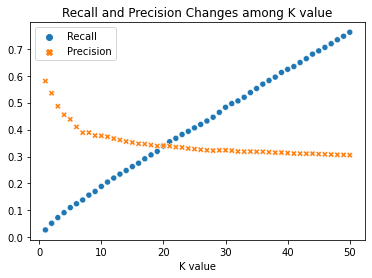

In [265]:
sns.scatterplot(data = d ).set(xlabel='K value', title ='Recall and Precision Changes among K value')

# THE END